In [12]:
import itertools
import pickle
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union
import matplotlib.colors as colors


In [13]:
def linear_G(delta: Union[float, np.array]):
    return np.maximum(0, delta)

def diminishing_returns_G(delta: Union[int, float, np.array]):
    return np.log(np.maximum(1, delta))

def linear_capped_G(delta: Union[int, float, np.array], lo_delta: float, hi_delta: float):
    return np.minimum(hi_delta, np.maximum(0, delta - lo_delta))

In [14]:
def normalize(x: np.array):
    return (x - np.min(x)) / np.ptp(x)

### **Load dictionaries** from pkl files

In [15]:
beta_params_range = np.arange(0.05, 10, 0.05)
price_range = np.arange(1, 101, 1) # Price range 0-100

# Linear prediction gain function
with open('params_to_profits_lin.pkl', 'rb') as f:
    params_to_profits = pickle.load(f)

In [16]:
df_dict = {
    'a': [],
    'b': [],
    'price': [],
    'no_ur_profit_avg': [],
    'ur_profit_avg': [],
}
for params, profits in params_to_profits.items():
    df_dict['a'].append(params[0])
    df_dict['b'].append(params[1])
    df_dict['price'].append(params[2])
    df_dict['no_ur_profit_avg'].append(profits['no_ur_profit_avg'])
    df_dict['ur_profit_avg'].append(profits['ur_profit_avg'])

In [18]:
df = pl.from_dict(df_dict, schema={'a': float, 'b': float, 'price': float, 'no_ur_profit_avg': float, 'ur_profit_avg': float})
df

shape: (3960100, 5)
┌──────┬──────┬───────┬──────────────────┬───────────────┐
│ a    ┆ b    ┆ price ┆ no_ur_profit_avg ┆ ur_profit_avg │
│ ---  ┆ ---  ┆ ---   ┆ ---              ┆ ---           │
│ f64  ┆ f64  ┆ f64   ┆ f64              ┆ f64           │
╞══════╪══════╪═══════╪══════════════════╪═══════════════╡
│ 0.05 ┆ 0.05 ┆ 1.0   ┆ 0.0              ┆ 47.979655     │
│ 0.05 ┆ 0.05 ┆ 2.0   ┆ 0.0              ┆ 47.463655     │
│ 0.05 ┆ 0.05 ┆ 3.0   ┆ 0.0              ┆ 46.948033     │
│ 0.05 ┆ 0.05 ┆ 4.0   ┆ 0.0              ┆ 46.433033     │
│ …    ┆ …    ┆ …     ┆ …                ┆ …             │
│ 9.95 ┆ 9.95 ┆ 97.0  ┆ 0.0              ┆ 0.003         │
│ 9.95 ┆ 9.95 ┆ 98.0  ┆ 0.0              ┆ 0.002         │
│ 9.95 ┆ 9.95 ┆ 99.0  ┆ 0.0              ┆ 0.001         │
│ 9.95 ┆ 9.95 ┆ 100.0 ┆ 0.0              ┆ 0.0           │
└──────┴──────┴───────┴──────────────────┴───────────────┘

### **Data processing**

Compute profits as percentage of price

In [19]:
df = df.with_columns(
    [
        (100 * pl.col('ur_profit_avg') / pl.col('price')).alias('ur_perc'),
        (100 * pl.col('no_ur_profit_avg') / pl.col('price')).alias('no_ur_perc')
    ]
)

df

shape: (3960100, 7)
┌──────┬──────┬───────┬──────────────────┬───────────────┬─────────────┬────────────┐
│ a    ┆ b    ┆ price ┆ no_ur_profit_avg ┆ ur_profit_avg ┆ ur_perc     ┆ no_ur_perc │
│ ---  ┆ ---  ┆ ---   ┆ ---              ┆ ---           ┆ ---         ┆ ---        │
│ f64  ┆ f64  ┆ f64   ┆ f64              ┆ f64           ┆ f64         ┆ f64        │
╞══════╪══════╪═══════╪══════════════════╪═══════════════╪═════════════╪════════════╡
│ 0.05 ┆ 0.05 ┆ 1.0   ┆ 0.0              ┆ 47.979655     ┆ 4797.965507 ┆ 0.0        │
│ 0.05 ┆ 0.05 ┆ 2.0   ┆ 0.0              ┆ 47.463655     ┆ 2373.182754 ┆ 0.0        │
│ 0.05 ┆ 0.05 ┆ 3.0   ┆ 0.0              ┆ 46.948033     ┆ 1564.934437 ┆ 0.0        │
│ 0.05 ┆ 0.05 ┆ 4.0   ┆ 0.0              ┆ 46.433033     ┆ 1160.825828 ┆ 0.0        │
│ …    ┆ …    ┆ …     ┆ …                ┆ …             ┆ …           ┆ …          │
│ 9.95 ┆ 9.95 ┆ 97.0  ┆ 0.0              ┆ 0.003         ┆ 0.003093    ┆ 0.0        │
│ 9.95 ┆ 9.95 ┆ 98.0  ┆ 0.0              ┆ 0.002         ┆ 0.002041    ┆ 0.0        │
│ 9.95 ┆ 9.95 ┆ 99.0  ┆ 0.0              ┆ 0.001         ┆ 0.00101     ┆ 0.0        │
│ 9.95 ┆ 9.95 ┆ 100.0 ┆ 0.0              ┆ 0.0           ┆ 0.0         ┆ 0.0        │
└──────┴──────┴───────┴──────────────────┴───────────────┴─────────────┴────────────┘

### **Preliminary analysis**

In [20]:
df.filter(pl.col('no_ur_profit_avg') > pl.col('ur_profit_avg'))

shape: (0, 7)
┌─────┬─────┬───────┬──────────────────┬───────────────┬─────────┬────────────┐
│ a   ┆ b   ┆ price ┆ no_ur_profit_avg ┆ ur_profit_avg ┆ ur_perc ┆ no_ur_perc │
│ --- ┆ --- ┆ ---   ┆ ---              ┆ ---           ┆ ---     ┆ ---        │
│ f64 ┆ f64 ┆ f64   ┆ f64              ┆ f64           ┆ f64     ┆ f64        │
╞═════╪═════╪═══════╪══════════════════╪═══════════════╪═════════╪════════════╡
└─────┴─────┴───────┴──────────────────┴───────────────┴─────────┴────────────┘

In [29]:
df.filter(pl.col('no_ur_perc') > pl.col('ur_perc'))

shape: (0, 7)
┌─────┬─────┬───────┬──────────────────┬───────────────┬─────────┬────────────┐
│ a   ┆ b   ┆ price ┆ no_ur_profit_avg ┆ ur_profit_avg ┆ ur_perc ┆ no_ur_perc │
│ --- ┆ --- ┆ ---   ┆ ---              ┆ ---           ┆ ---     ┆ ---        │
│ f64 ┆ f64 ┆ f64   ┆ f64              ┆ f64           ┆ f64     ┆ f64        │
╞═════╪═════╪═══════╪══════════════════╪═══════════════╪═════════╪════════════╡
└─────┴─────┴───────┴──────────────────┴───────────────┴─────────┴────────────┘

Therefore, UR is always better on average, no matter the price.

What is the distribution of the differences between the two?

In [33]:
df_diff = None

In [ ]:
df_both_greater_0 = df.filter((pl.col("ur_profit_avg") > 0) & (pl.col("no_ur_profit_avg") > 0))

### **Summary Statistics**

In [31]:
def mad(arr, axis=None, keepdims=True):
    median = np.median(arr, axis=axis, keepdims=True)
    mad = np.median(np.abs(arr-median),axis=axis, keepdims=keepdims)
    return mad[0]

def summary_stats(col):
    mean = col.mean()
    median = col.median()
    std = col.std()
    var = col.var()
    skew = col.skew()
    kurt = col.kurtosis()
    mx = col.max()
    mean_abs_dev = mad(col.to_numpy())
    print(f'Mean = {mean:.3f}')
    print(f'Median = {median:.3f}')
    print(f'Std = {std:.3f}')
    print(f'Var = {var:.3f}')
    print(f'Skew = {skew:.3f}')
    print(f'Kurtosis = {kurt:.3f}')
    print(f'Max = {mx:.3f}')
    print(f'Mad = {mean_abs_dev:.3f}')

In [32]:
print('UR (unfiltered)')
summary_stats(df['ur_profit_avg'])


print('No UR (unfiltered)')
summary_stats(df['no_ur_profit_avg'])

UR (unfiltered)
Mean = 8.390
Median = 1.212
Std = 15.304
Var = 234.225
Skew = 2.597
Kurtosis = 7.001
Max = 97.256
Mad = 1.203
No UR (unfiltered)
Mean = 6.070
Median = 0.000
Std = 15.304
Var = 234.215
Skew = 2.912
Kurtosis = 8.429
Max = 97.255
Mad = 0.000


In [24]:
print('UR (both greater than 0)')
summary_stats(df_both_greater_0['ur_profit_avg'])


print('No UR (both greater than 0)')
summary_stats(df_both_greater_0['no_ur_profit_avg'])

UR (both greater than 0)
Mean = 33.346
Median = 28.126
Std = 18.723
Skew = 0.978
Kurtosis = 0.274
Max = 97.256
Mad = 11.262
No UR (both greater than 0)
Mean = 30.471
Median = 25.808
Std = 20.790
Skew = 0.794
Kurtosis = -0.073
Max = 97.255
Mad = 13.616


In [41]:
a = np.array([1, 4, -1, 0, 2])
b = np.array([0, 0, 0, 0, 0])

idxs = np.where(a > 0)
idxs

b[idxs] = a[idxs]
b

array([1, 4, 0, 0, 2])

Profit as percentage of price

In [25]:
print('UR (unfiltered)')
summary_stats(df['ur_perc'])

print('UR (unfiltered)')
summary_stats(df['no_ur_perc'])

UR (unfiltered)
Mean = 92.970
Median = 2.927
Std = 428.979
Skew = 11.403
Kurtosis = 172.181
Max = 9725.577
Mad = 2.919
UR (unfiltered)
Mean = 77.229
Median = 0.000
Std = 424.774
Skew = 11.769
Kurtosis = 180.427
Max = 9725.477
Mad = 0.000


Plot distribution with UR

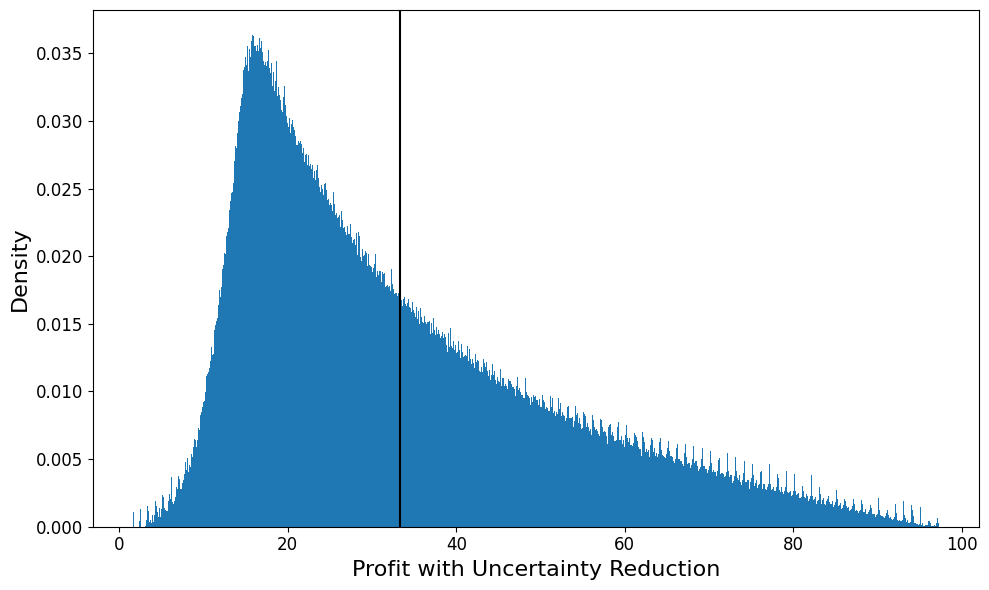

In [146]:
fig,ax = plt.subplots(figsize=(10, 6)) 

ax.hist(df_both_greater_0['ur_profit_avg'], bins=1000, density=True)

plt.xlabel(f'Profit with Uncertainty Reduction', fontsize=16)
plt.ylabel(f'Density', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.axvline(x=df_both_greater_0['ur_profit_avg'].mean(), color='black')

plt.tight_layout()
plt.show()

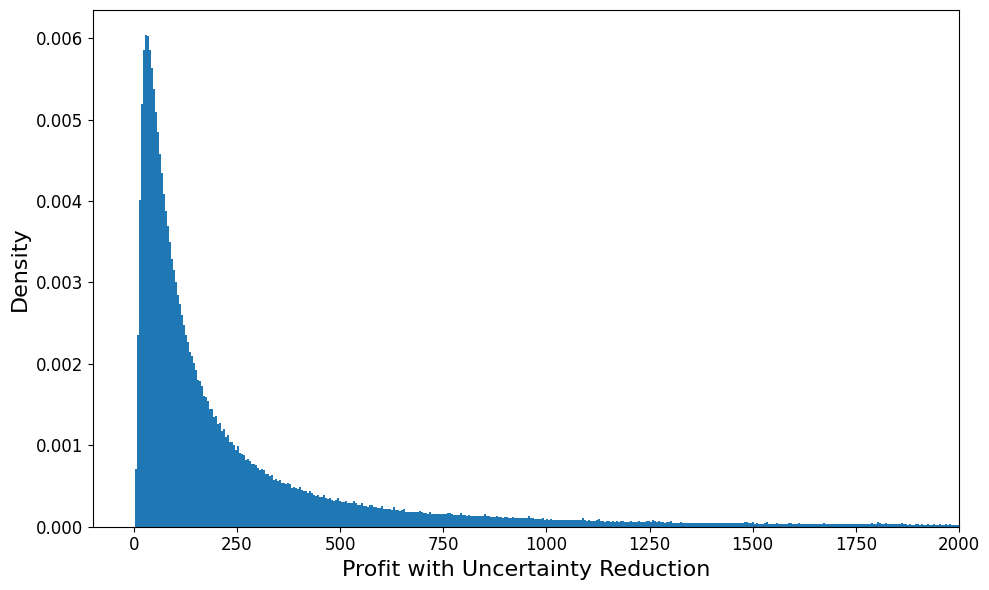

In [144]:
fig,ax = plt.subplots(figsize=(10, 6)) 

ax.hist(df_both_greater_0['ur_perc'], bins=2000, density=True)

plt.xlabel(f'Profit with Uncertainty Reduction', fontsize=16)
plt.ylabel(f'Density', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.xlim((-100, 2000))
plt.tight_layout()
plt.show()

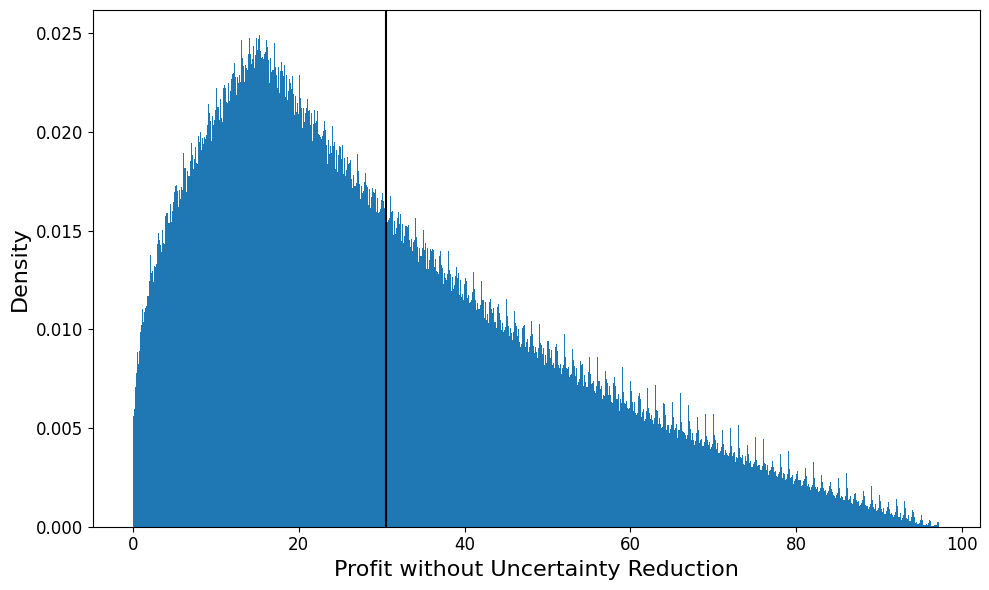

In [147]:
fig,ax = plt.subplots(figsize=(10, 6)) 

ax.hist(df_both_greater_0['no_ur_profit_avg'], bins=1000, density=True)

plt.xlabel(f'Profit without Uncertainty Reduction', fontsize=16)
plt.ylabel(f'Density', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.axvline(x=df_both_greater_0['no_ur_profit_avg'].mean(), color='black')


plt.tight_layout()
plt.show()

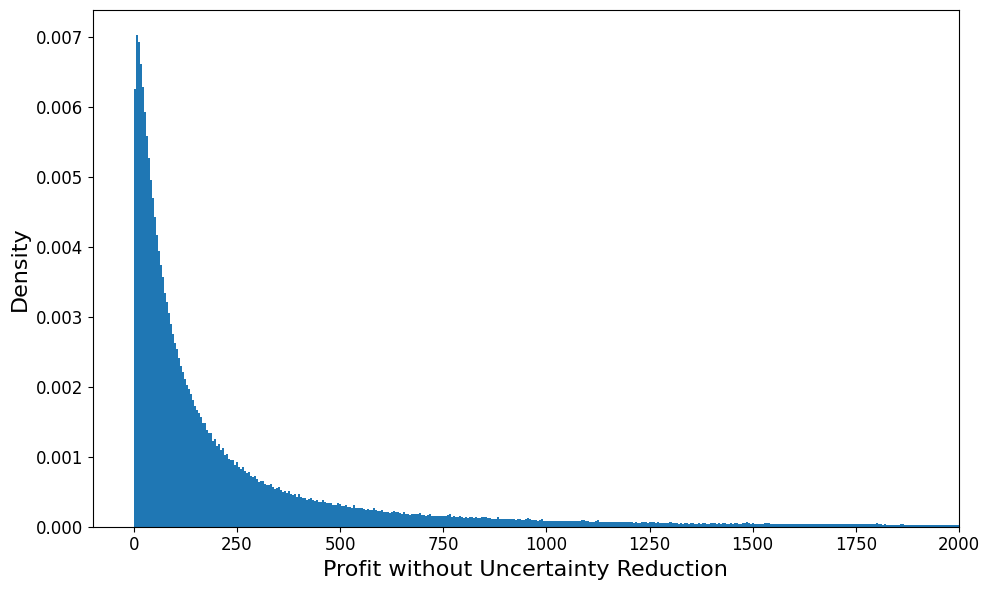

In [145]:
fig,ax = plt.subplots(figsize=(10, 6)) 

ax.hist(df_both_greater_0['no_ur_perc'], bins=2000, density=True)

plt.xlabel(f'Profit without Uncertainty Reduction', fontsize=16)
plt.ylabel(f'Density', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.xlim((-100, 2000))

plt.tight_layout()
plt.show()

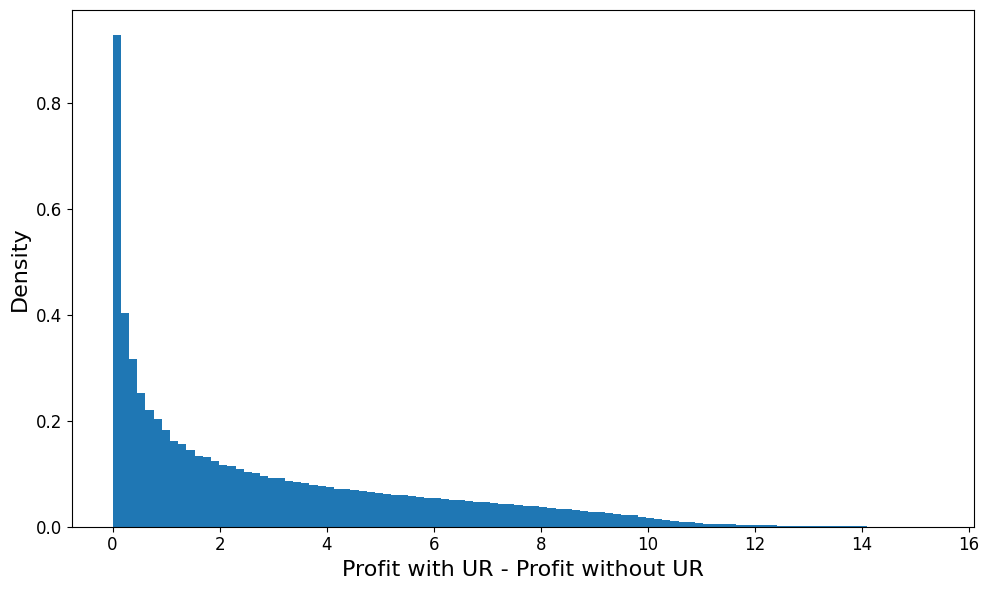

In [39]:
fig,ax = plt.subplots(figsize=(10, 6)) 
ax.hist(df_both_greater_0["ur_profit_avg"] - df_both_greater_0["no_ur_profit_avg"], bins=100, edgecolor='None', density=True)

plt.xlabel(f'Profit with UR - Profit without UR', fontsize=16)
plt.ylabel(f'Density', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.tight_layout()
plt.show()

### Joint distribution with and without UR

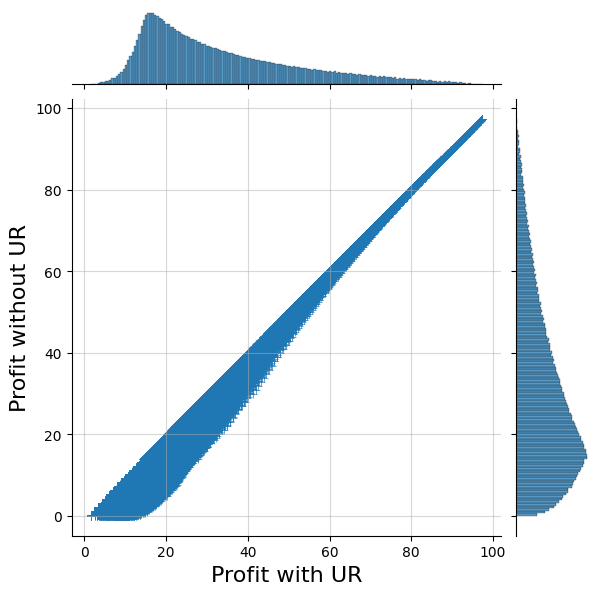

In [84]:
# sns.displot(data=df_sample, x="ur_profit_avg", y="no_ur_profit_avg", kind="kde", rug=True)
sns.jointplot(data=df_both_greater_0, x="ur_profit_avg", y="no_ur_profit_avg", marker='+')

plt.xlabel(f'Profit with UR', fontsize=16)
plt.ylabel(f'Profit without UR', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.grid(alpha=0.5)

plt.show()

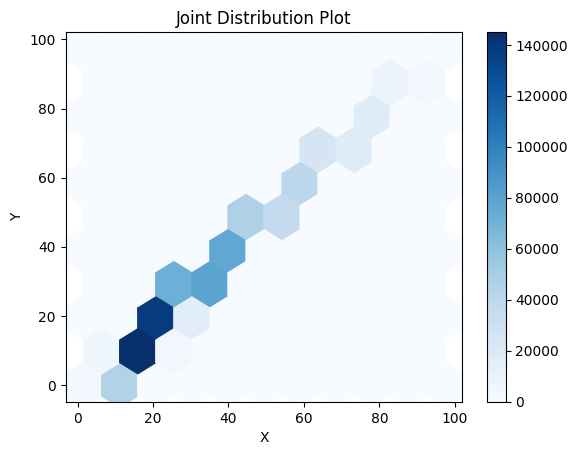

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
x = df_both_greater_0['ur_profit_avg']
y = df_both_greater_0['no_ur_profit_avg']

# Create the joint distribution plot
plt.hexbin(x, y, gridsize=10, cmap='Blues')
plt.colorbar()

# Add axis labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Joint Distribution Plot')

# Show the plot
plt.show()

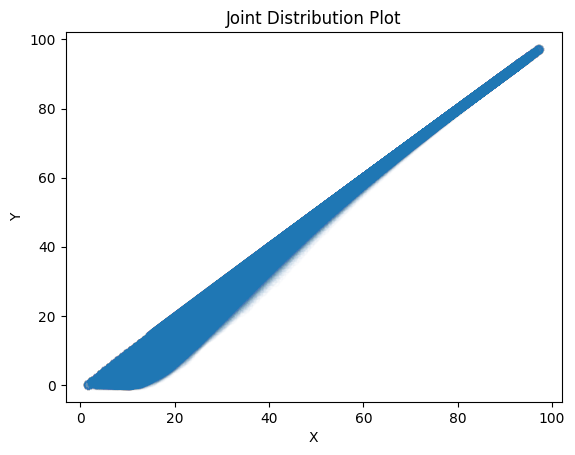

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
x = df_both_greater_0['ur_profit_avg']
y = df_both_greater_0['no_ur_profit_avg']


# Create the joint distribution plot
plt.scatter(x, y, alpha=0.01)

# Add axis labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Joint Distribution Plot')

# Show the plot
plt.show()


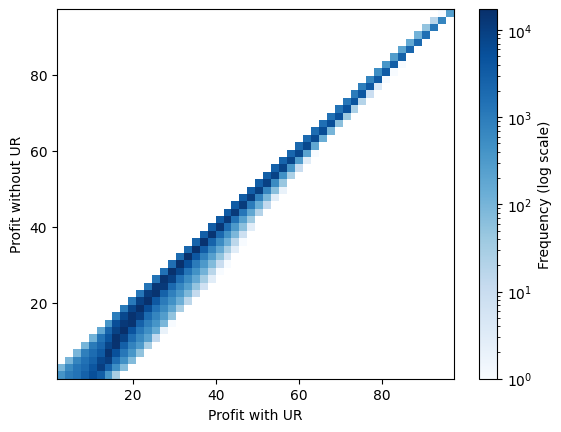

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
x = df_both_greater_0['ur_profit_avg']
y = df_both_greater_0['no_ur_profit_avg']

norm = colors.LogNorm(vmin=counts.min(), vmax=counts.max())

# Create the joint distribution plot
counts, xedges, yedges, _ = plt.hist2d(x, y, bins=50, cmap='Blues', norm=colors.LogNorm())

# Add color bar
norm = colors.LogNorm(vmin=counts.min(), vmax=counts.max())
cbar = plt.colorbar(norm=norm)

# Set the label for the colorbar
cbar.set_label('Frequency (log scale)')

plt.xlabel('Profit with UR')
plt.ylabel('Profit without UR')

# Show the plot
plt.show()


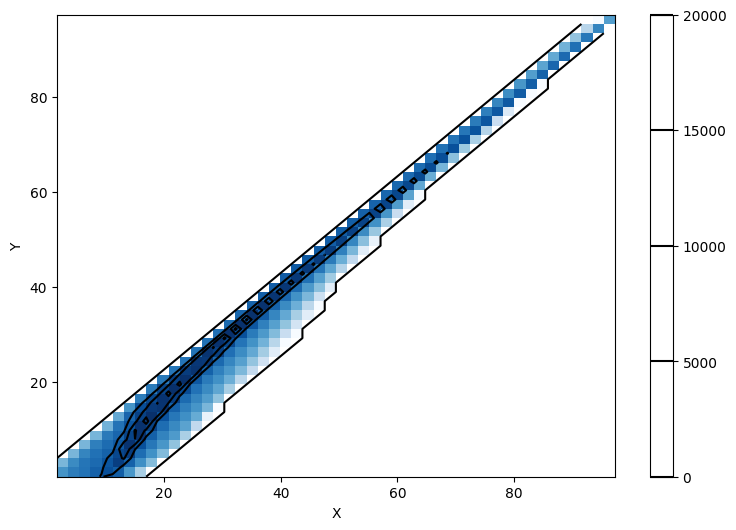

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
x = df_both_greater_0['ur_profit_avg']
y = df_both_greater_0['no_ur_profit_avg']


# Create a 2D histogram to get the density
counts, xedges, yedges, _ = plt.hist2d(x, y, bins=50, cmap='Blues', norm=colors.LogNorm())

# Create a grid of points to evaluate the density at
xgrid, ygrid = np.meshgrid(xedges[:-1], yedges[:-1])

# Evaluate the density at each point in the grid
density = np.transpose(counts)

# Create the joint distribution plot
plt.contour(xgrid, ygrid, density, levels=3, colors='k')

# Add color bar and axis labels
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')

# Show the plot
plt.show()


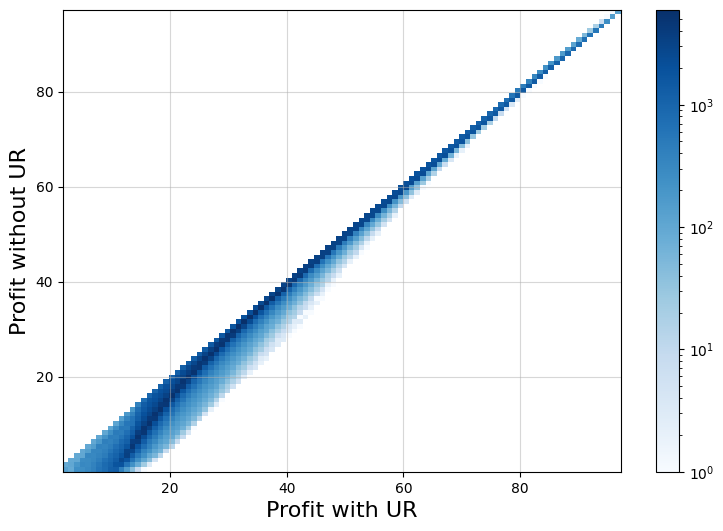

In [86]:
# Generate some data
x = df_both_greater_0['ur_profit_avg']
y = df_both_greater_0['no_ur_profit_avg']

plt.rcParams["figure.figsize"] = (9, 6)

# Create the joint distribution plot
plt.hist2d(x, y, bins=100, cmap='Blues', norm=colors.LogNorm())

# Add color bar and axis labels
plt.colorbar()
plt.xlabel('Profit with UR', fontsize=16)
plt.ylabel('Profit without UR', fontsize=16)

plt.grid(alpha=0.5)

# Show the plot
plt.show()


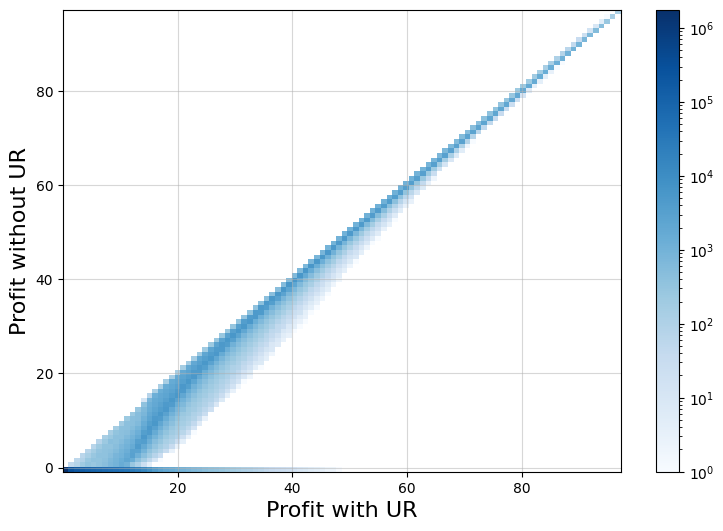

In [90]:
df_different = df.filter(pl.col("ur_profit_avg") != pl.col("no_ur_profit_avg"))

# Generate some data
x = df_different['ur_profit_avg']
y = df_different['no_ur_profit_avg']

plt.rcParams["figure.figsize"] = (9, 6)

# Create the joint distribution plot
plt.hist2d(x, y, bins=100, cmap='Blues', norm=colors.LogNorm())

# Add color bar and axis labels
plt.colorbar()
plt.xlabel('Profit with UR', fontsize=16)
plt.ylabel('Profit without UR', fontsize=16)

plt.grid(alpha=0.5)

# Show the plot
plt.show()

Both greater than 0

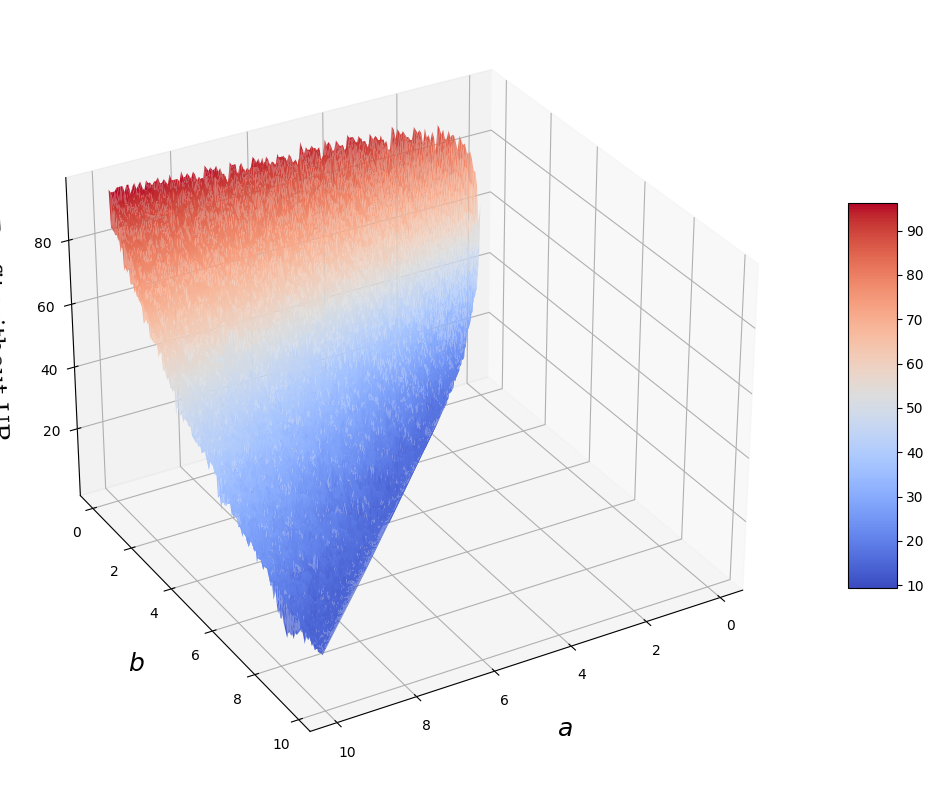

In [19]:
fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection='3d')

a = df_both_greater_0['a'].to_numpy()
b = df_both_greater_0['b'].to_numpy()
no_ur_profit_avg = df_both_greater_0['no_ur_profit_avg'].to_numpy()

surf = ax.plot_trisurf(a, b, no_ur_profit_avg, cmap=plt.cm.coolwarm)

# Set axes label
fontdict = {
  'family': 'serif',
  'color':  'black',
  'weight': 'normal',
  'size': 18,
}
ax.set_xlabel('$a$', labelpad=15, fontdict=fontdict)
ax.set_ylabel('$b$', labelpad=15, fontdict=fontdict)
ax.set_zlabel('Profit without UR', labelpad=15, fontdict=fontdict)

# ax_xlocator = FixedLocator(np.log(cv_mean_mse_df['gamma'].unique()))
# ax_ylocator = FixedLocator(np.log(cv_mean_mse_df['sigma'].unique()))
# ax.xaxis.set_major_locator(ax_xlocator)
# ax.yaxis.set_major_locator(ax_ylocator)

# ax.xaxis.set_major_formatter(gamma_formatter)
# ax.yaxis.set_major_formatter(sigma_formatter)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.tight_layout()
ax.view_init(30, 60)
plt.show()

Different

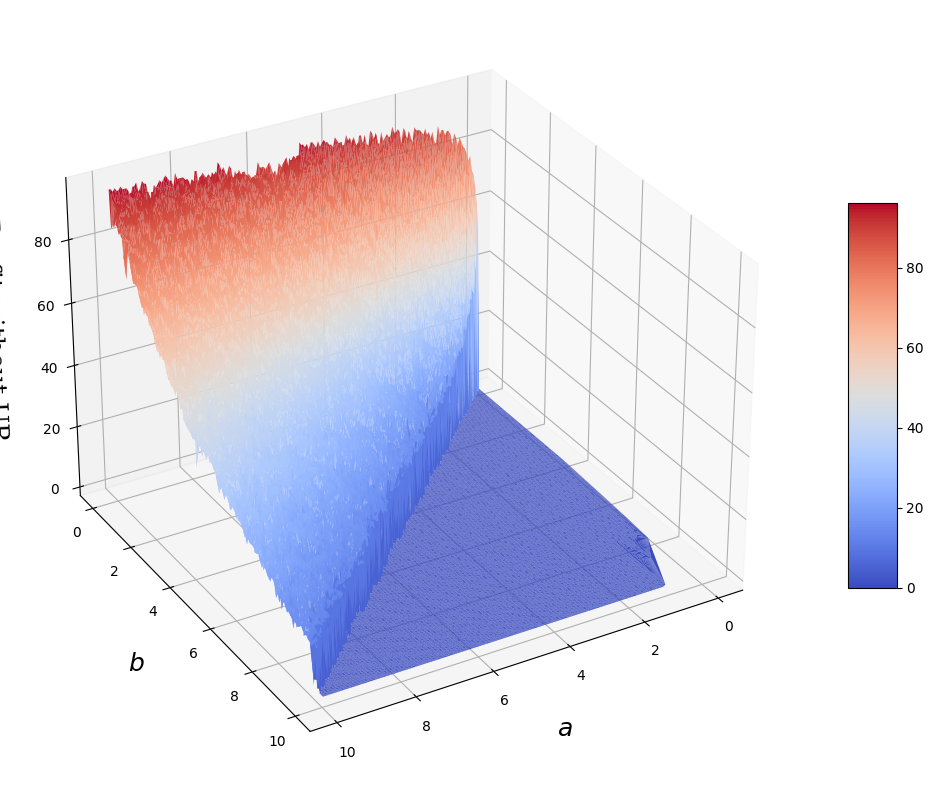

In [89]:
df_different = df.filter(pl.col("ur_profit_avg") != pl.col("no_ur_profit_avg"))

fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection='3d')

a = df_different['a'].to_numpy()
b = df_different['b'].to_numpy()
no_ur_profit_avg = df_different['no_ur_profit_avg'].to_numpy()

surf = ax.plot_trisurf(a, b, no_ur_profit_avg, cmap=plt.cm.coolwarm)

# Set axes label
fontdict = {
  'family': 'serif',
  'color':  'black',
  'weight': 'normal',
  'size': 18,
}
ax.set_xlabel('$a$', labelpad=15, fontdict=fontdict)
ax.set_ylabel('$b$', labelpad=15, fontdict=fontdict)
ax.set_zlabel('Profit without UR', labelpad=15, fontdict=fontdict)

# ax_xlocator = FixedLocator(np.log(cv_mean_mse_df['gamma'].unique()))
# ax_ylocator = FixedLocator(np.log(cv_mean_mse_df['sigma'].unique()))
# ax.xaxis.set_major_locator(ax_xlocator)
# ax.yaxis.set_major_locator(ax_ylocator)

# ax.xaxis.set_major_formatter(gamma_formatter)
# ax.yaxis.set_major_formatter(sigma_formatter)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.tight_layout()
ax.view_init(30, 60)
plt.show()

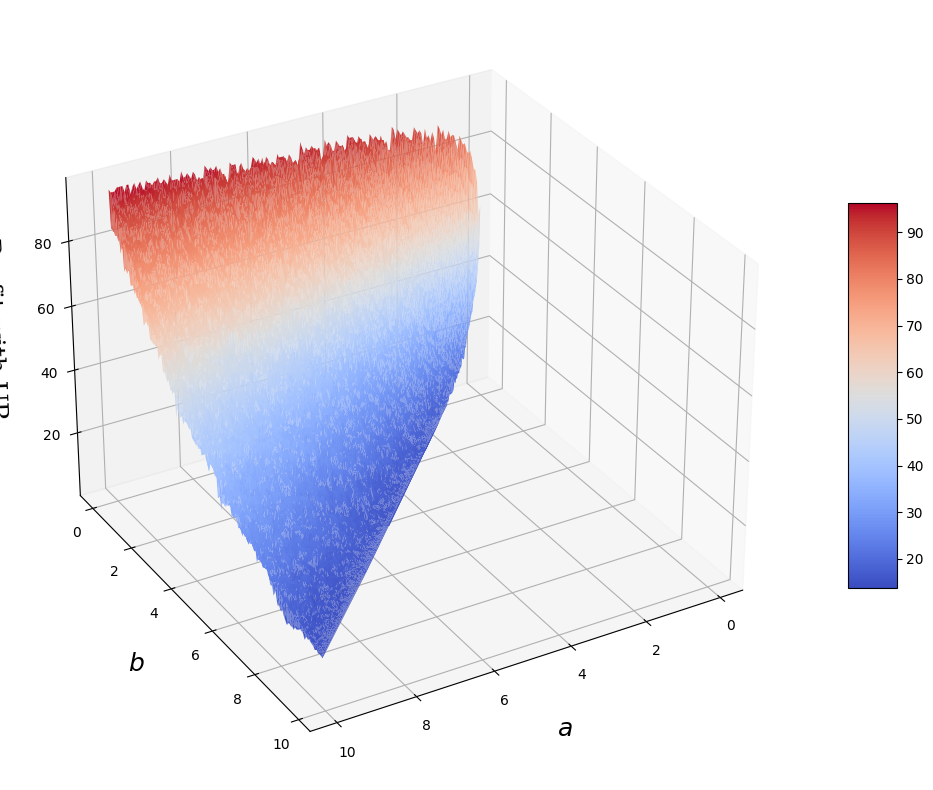

In [20]:
fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection='3d')

a = df_both_greater_0['a'].to_numpy()
b = df_both_greater_0['b'].to_numpy()
no_ur_profit_avg = df_both_greater_0['ur_profit_avg'].to_numpy()

surf = ax.plot_trisurf(a, b, no_ur_profit_avg, cmap=plt.cm.coolwarm)

# Set axes label
fontdict = {
  'family': 'serif',
  'color':  'black',
  'weight': 'normal',
  'size': 18,
}
ax.set_xlabel('$a$', labelpad=15, fontdict=fontdict)
ax.set_ylabel('$b$', labelpad=15, fontdict=fontdict)
ax.set_zlabel('Profit with UR', labelpad=15, fontdict=fontdict)

# ax_xlocator = FixedLocator(np.log(cv_mean_mse_df['gamma'].unique()))
# ax_ylocator = FixedLocator(np.log(cv_mean_mse_df['sigma'].unique()))
# ax.xaxis.set_major_locator(ax_xlocator)
# ax.yaxis.set_major_locator(ax_ylocator)

# ax.xaxis.set_major_formatter(gamma_formatter)
# ax.yaxis.set_major_formatter(sigma_formatter)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.tight_layout()
ax.view_init(30, 60)
plt.show()

### Aggregate across prices

In [21]:
query = (
    df.lazy()
    .groupby(['a', 'b'])
    .agg(
        [   
            pl.col('no_ur_profit_avg').mean().alias('no_ur_profit_avg'),
            pl.col('no_ur_profit_avg').median().alias('no_ur_profit_avg_median'),
            pl.col('no_ur_profit_avg').std().alias('no_ur_profit_avg_std'),
            
            pl.col('ur_profit_avg').mean().alias('ur_profit_avg'),
            pl.col('ur_profit_avg').median().alias('ur_profit_avg_median'),
            pl.col('ur_profit_avg').std().alias('ur_profit_avg_std'),
        ]
    )
)

df_agg = query.collect()
df_agg

shape: (39601, 8)
┌──────┬──────┬────────────┬────────────┬────────────┬───────────────┬──────────────┬──────────────┐
│ a    ┆ b    ┆ no_ur_prof ┆ no_ur_prof ┆ no_ur_prof ┆ ur_profit_avg ┆ ur_profit_av ┆ ur_profit_av │
│ ---  ┆ ---  ┆ it_avg     ┆ it_avg_med ┆ it_avg_std ┆ ---           ┆ g_median     ┆ g_std        │
│ f64  ┆ f64  ┆ ---        ┆ ian        ┆ ---        ┆ f64           ┆ ---          ┆ ---          │
│      ┆      ┆ f64        ┆ ---        ┆ f64        ┆               ┆ f64          ┆ f64          │
│      ┆      ┆            ┆ f64        ┆            ┆               ┆              ┆              │
╞══════╪══════╪════════════╪════════════╪════════════╪═══════════════╪══════════════╪══════════════╡
│ 1.25 ┆ 7.4  ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.065602      ┆ 0.0495       ┆ 0.055115     │
│ 1.25 ┆ 7.65 ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.055783      ┆ 0.0495       ┆ 0.039287     │
│ 1.25 ┆ 7.9  ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.051158      ┆ 0.0495       ┆ 0.031893     │
│ 1.25 ┆ 8.05 ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.049755      ┆ 0.0495       ┆ 0.029454     │
│ …    ┆ …    ┆ …          ┆ …          ┆ …          ┆ …             ┆ …            ┆ …            │
│ 2.45 ┆ 9.1  ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.157331      ┆ 0.073919     ┆ 0.175325     │
│ 2.45 ┆ 9.35 ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.14003       ┆ 0.068639     ┆ 0.154665     │
│ 2.45 ┆ 9.6  ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.123801      ┆ 0.064583     ┆ 0.133636     │
│ 2.45 ┆ 9.85 ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.109082      ┆ 0.062666     ┆ 0.113002     │
└──────┴──────┴────────────┴────────────┴────────────┴───────────────┴──────────────┴──────────────┘

### Comparison between with and without UR (averaged across prices)

In [22]:
df_agg.filter(pl.col('no_ur_profit_avg') > pl.col('ur_profit_avg'))

shape: (0, 8)
┌─────┬─────┬────────────┬────────────┬───────────────┬──────────────┬──────────────┬──────────────┐
│ a   ┆ b   ┆ no_ur_prof ┆ no_ur_prof ┆ no_ur_profit_ ┆ ur_profit_av ┆ ur_profit_av ┆ ur_profit_av │
│ --- ┆ --- ┆ it_avg     ┆ it_avg_med ┆ avg_std       ┆ g            ┆ g_median     ┆ g_std        │
│ f64 ┆ f64 ┆ ---        ┆ ian        ┆ ---           ┆ ---          ┆ ---          ┆ ---          │
│     ┆     ┆ f64        ┆ ---        ┆ f64           ┆ f64          ┆ f64          ┆ f64          │
│     ┆     ┆            ┆ f64        ┆               ┆              ┆              ┆              │
╞═════╪═════╪════════════╪════════════╪═══════════════╪══════════════╪══════════════╪══════════════╡
└─────┴─────┴────────────┴────────────┴───────────────┴──────────────┴──────────────┴──────────────┘

Therefore, UR is always better on average (averaged across prices).

What is the distribution of the differences between the two?

### Plot expected profits surface/countour (with and without UR) w.r.t. all a, b

Without UR

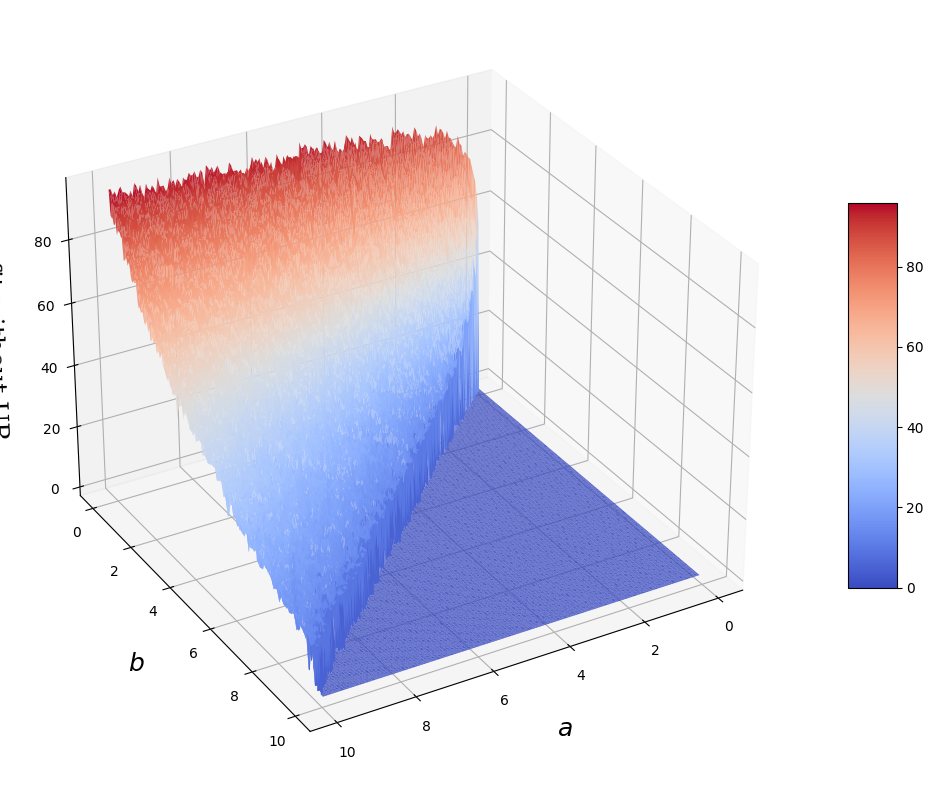

In [23]:
# from matplotlib.ticker import FuncFormatter, LogFormatterExponent, LogFormatterSciNotation, LogFormatterMathtext, LogLocator, SymmetricalLogLocator, FixedLocator
# from matplotlib import animation

fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection='3d')

a = df['a'].to_numpy()
b = df['b'].to_numpy()
no_ur_profit_avg = df['no_ur_profit_avg'].to_numpy()

surf = ax.plot_trisurf(a, b, no_ur_profit_avg, cmap=plt.cm.coolwarm)

# Set axes label
fontdict = {
  'family': 'serif',
  'color':  'black',
  'weight': 'normal',
  'size': 18,
}
ax.set_xlabel('$a$', labelpad=15, fontdict=fontdict)
ax.set_ylabel('$b$', labelpad=15, fontdict=fontdict)
ax.set_zlabel('profit without UR', labelpad=15, fontdict=fontdict)

# ax_xlocator = FixedLocator(np.log(cv_mean_mse_df['gamma'].unique()))
# ax_ylocator = FixedLocator(np.log(cv_mean_mse_df['sigma'].unique()))
# ax.xaxis.set_major_locator(ax_xlocator)
# ax.yaxis.set_major_locator(ax_ylocator)

# ax.xaxis.set_major_formatter(gamma_formatter)
# ax.yaxis.set_major_formatter(sigma_formatter)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.tight_layout()
ax.view_init(30, 60)
plt.show()

With UR

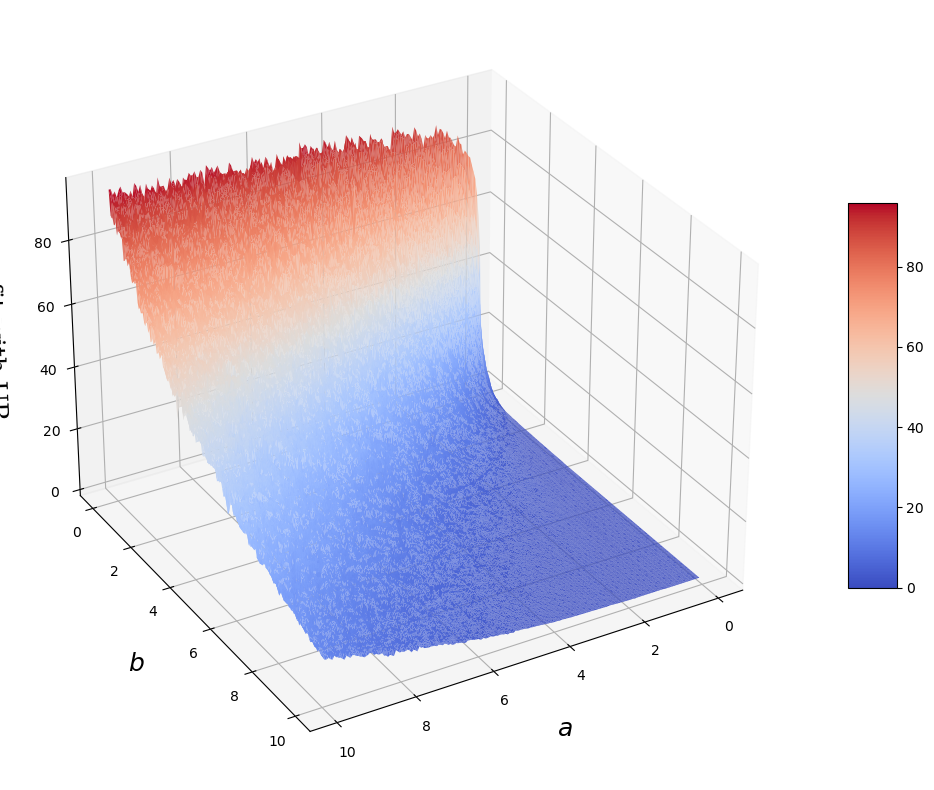

In [32]:
fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection='3d')

a = df['a'].to_numpy()
b = df['b'].to_numpy()
ur_profit_avg = df['ur_profit_avg'].to_numpy()

surf = ax.plot_trisurf(a, b, ur_profit_avg, cmap=plt.cm.coolwarm)

# Set axes label
fontdict = {
  'family': 'serif',
  'color':  'black',
  'weight': 'normal',
  'size': 18,
}
ax.set_xlabel('$a$', labelpad=15, fontdict=fontdict)
ax.set_ylabel('$b$', labelpad=15, fontdict=fontdict)
ax.set_zlabel('profit with UR', labelpad=15, fontdict=fontdict)

ax.view_init(30, 60)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.tight_layout()
plt.show()

Profit difference between the two strategies

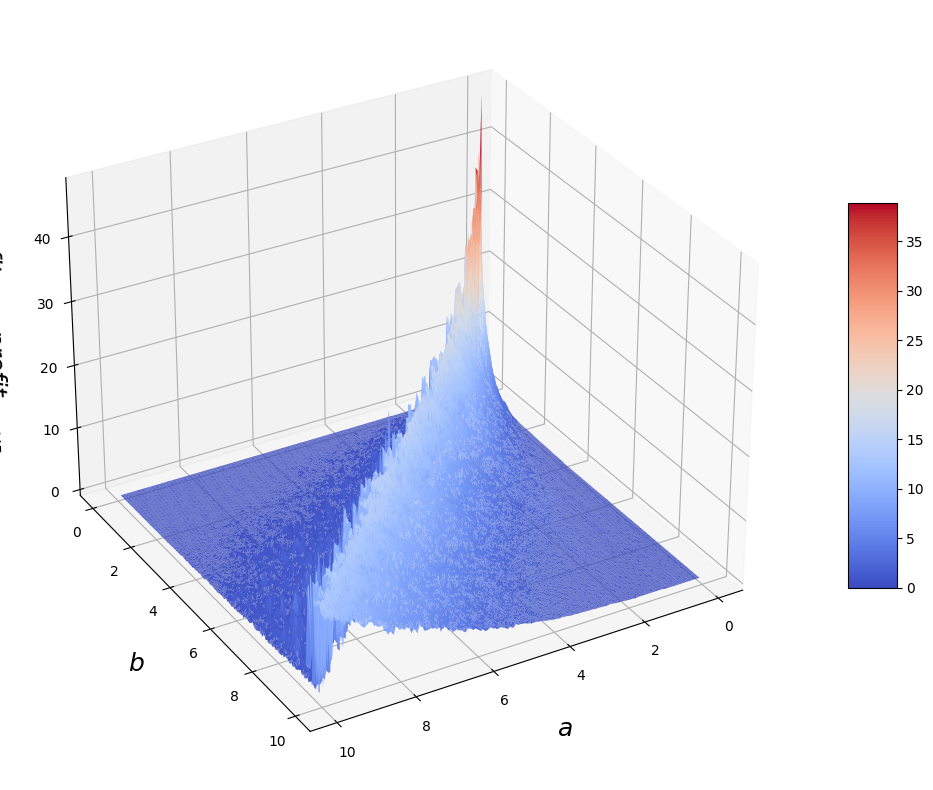

In [124]:
fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection='3d')

a = df['a'].to_numpy()
b = df['b'].to_numpy()
profit_avg_diff = df['ur_profit_avg'].to_numpy() - df['no_ur_profit_avg'].to_numpy()

surf = ax.plot_trisurf(a, b, profit_avg_diff, cmap=plt.cm.coolwarm)

# Set axes label
fontdict = {
  'family': 'serif',
  'color':  'black',
  'weight': 'normal',
  'size': 18,
}
ax.set_xlabel('$a$', labelpad=15, fontdict=fontdict)
ax.set_ylabel('$b$', labelpad=15, fontdict=fontdict)
ax.set_zlabel('$profit_{UR} - profit_{nonUR}$', labelpad=15, fontdict=fontdict)

ax.view_init(30, 60)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.tight_layout()
plt.savefig('diff_profits.png', dpi=250)
plt.show()

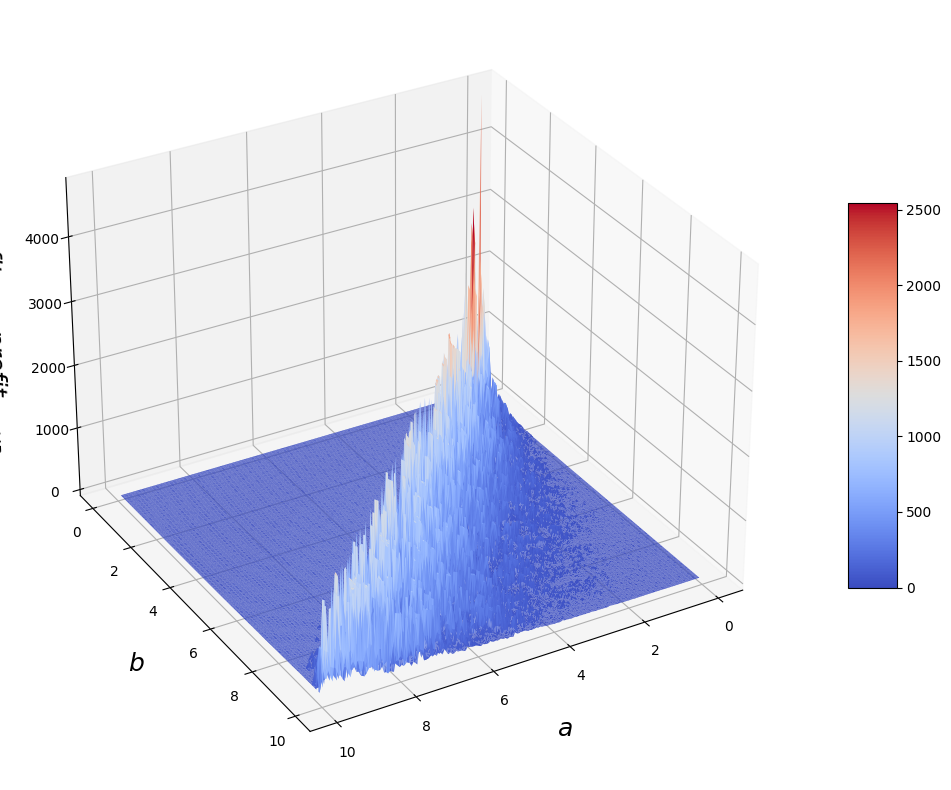

In [137]:
fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection='3d')


a = df['a'].to_numpy()
b = df['b'].to_numpy()
profit_avg_diff = df['ur_perc'].to_numpy() - df['no_ur_perc'].to_numpy()

surf = ax.plot_trisurf(a, b, profit_avg_diff, cmap=plt.cm.coolwarm)

# Set axes label
fontdict = {
  'family': 'serif',
  'color':  'black',
  'weight': 'normal',
  'size': 18,
}
ax.set_xlabel('$a$', labelpad=15, fontdict=fontdict)
ax.set_ylabel('$b$', labelpad=15, fontdict=fontdict)
ax.set_zlabel('$profit_{UR} - profit_{nonUR}$', labelpad=15, fontdict=fontdict)

ax.view_init(30, 60)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.tight_layout()
plt.show()

In [159]:
print('UR')
mean = df['ur_profit_avg'].mean()
median = df['ur_profit_avg'].median()
std = df['ur_profit_avg'].std()
skew = df['ur_profit_avg'].skew()
kurt = df['ur_profit_avg'].kurtosis()
mx = df['ur_profit_avg'].max()
mean_abs_dev = mad(df['ur_profit_avg'].to_numpy())
print(f'Mean = {mean:.3f}')
print(f'Median = {median:.3f}')
print(f'Std = {std:.3f}')
print(f'Skew = {skew:.3f}')
print(f'Kurtosis = {kurt:.3f}')
print(f'Max = {mx:.3f}')
print(f'Mad = {mean_abs_dev:.3f}')


print('No UR')
mean = df['no_ur_profit_avg'].mean()
median = df['no_ur_profit_avg'].median()
std = df['no_ur_profit_avg'].std()
skew = df['no_ur_profit_avg'].skew()
kurt = df['no_ur_profit_avg'].kurtosis()
mx = df['no_ur_profit_avg'].max()
mean_abs_dev = mad(df['no_ur_profit_avg'].to_numpy())
print(f'Mean = {mean:.3f}')
print(f'Median = {median:.3f}')
print(f'Std = {std:.3f}')
print(f'Skew = {skew:.3f}')
print(f'Kurtosis = {kurt:.3f}')
print(f'Max = {mx:.3f}')
print(f'Mad = {mean_abs_dev:.3f}')

UR
Mean = 8.390
Median = 1.212
Std = 15.304
Skew = 2.597
Kurtosis = 7.001
Max = 97.256
Mad = 1.203
No UR
Mean = 6.070
Median = 0.000
Std = 15.304
Skew = 2.912
Kurtosis = 8.429
Max = 97.255
Mad = 0.000


In [162]:
20.790 - 18.723

2.067

In [161]:
100* (df.shape[0] - df_both_greater_0.shape[0]) / df.shape[0]

80.07977071286079

UR
Mean = 92.970
Median = 2.927
Std = 428.979
Skew = 11.403
Kurtosis = 172.181
Max = 9725.577
No UR
Mean = 77.229
Median = 0.000
Std = 424.774
Skew = 11.769
Kurtosis = 180.427
Max = 9725.477


Plot standard deviation without UR

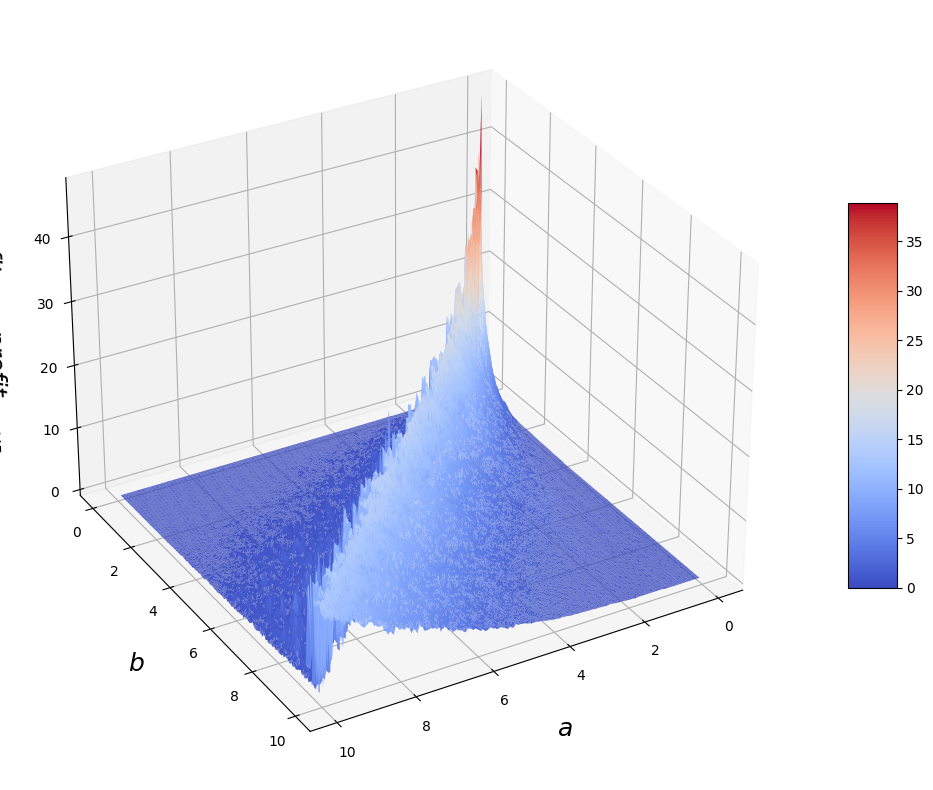

In [25]:
fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection='3d')

a = df['a'].to_numpy()
b = df['b'].to_numpy()
profit_avg_diff = df['ur_profit_avg'].to_numpy() - df['no_ur_profit_avg'].to_numpy()

surf = ax.plot_trisurf(a, b, profit_avg_diff, cmap=plt.cm.coolwarm)

# Set axes label
fontdict = {
  'family': 'serif',
  'color':  'black',
  'weight': 'normal',
  'size': 18,
}
ax.set_xlabel('$a$', labelpad=15, fontdict=fontdict)
ax.set_ylabel('$b$', labelpad=15, fontdict=fontdict)
ax.set_zlabel('$profit_{UR} - profit_{nonUR}$', labelpad=15, fontdict=fontdict)

ax.view_init(30, 60)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.tight_layout()
plt.show()

### Plot mean, mode and stdev of profits (with and without UR) w.r.t. to all a, b

In [26]:
# fig = plt.figure(figsize = (14, 8))
# ax = plt.axes(projection='3d')

# a = df_agg['a'].to_numpy()
# b = df_agg['b'].to_numpy()
# std_ur = df_agg['ur_profit_avg_std'].to_numpy()

# surf = ax.plot_trisurf(a, b, std_ur, cmap=plt.cm.coolwarm)

# # Set axes label
# fontdict = {
#   'family': 'serif',
#   'color':  'black',
#   'weight': 'normal',
#   'size': 18,
# }
# ax.set_xlabel('$a$', labelpad=15, fontdict=fontdict)
# ax.set_ylabel('$b$', labelpad=15, fontdict=fontdict)
# ax.set_zlabel('$profit_{UR} - profit_{nonUR}$', labelpad=15, fontdict=fontdict)

# ax.view_init(30, 60)

# fig.colorbar(surf, shrink=0.5, aspect=8)
# plt.tight_layout()
# plt.show()

### Illustrate beta distirbution with profit estimate and true profit for a specific choice of a, b

In [25]:
df.write_csv('results.csv')

In [29]:
beta_params_range

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
       1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65,
       1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15, 2.2 ,
       2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 , 2.75,
       2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25, 3.3 ,
       3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 , 3.85,
       3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35, 4.4 ,
       4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 , 4.95,
       5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35, 5.4 , 5.45, 5.5 ,
       5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 , 5.95, 6.  , 6.05,
       6.1 , 6.15, 6.2 , 6.25, 6.3 , 6.35, 6.4 , 6.45, 6.5 , 6.55, 6.6 ,
       6.65, 6.7 , 6.75, 6.8 , 6.85, 6.9 , 6.95, 7.  , 7.05, 7.1 , 7.15,
       7.2 , 7.25, 7.3 , 7.35, 7.4 , 7.45, 7.5 , 7.

In [27]:
df_single_ab = df.filter((pl.col('a') == 4.75) & (pl.col('b') == 6.4))
df_single_ab

shape: (100, 5)
┌──────┬─────┬───────┬──────────────────┬───────────────┐
│ a    ┆ b   ┆ price ┆ no_ur_profit_avg ┆ ur_profit_avg │
│ ---  ┆ --- ┆ ---   ┆ ---              ┆ ---           │
│ f64  ┆ f64 ┆ f64   ┆ f64              ┆ f64           │
╞══════╪═════╪═══════╪══════════════════╪═══════════════╡
│ 4.75 ┆ 6.4 ┆ 1.0   ┆ 0.0              ┆ 8.788105      │
│ 4.75 ┆ 6.4 ┆ 2.0   ┆ 0.0              ┆ 8.501518      │
│ 4.75 ┆ 6.4 ┆ 3.0   ┆ 0.0              ┆ 8.22285       │
│ 4.75 ┆ 6.4 ┆ 4.0   ┆ 0.0              ┆ 7.949743      │
│ …    ┆ …   ┆ …     ┆ …                ┆ …             │
│ 4.75 ┆ 6.4 ┆ 97.0  ┆ 0.0              ┆ 0.003         │
│ 4.75 ┆ 6.4 ┆ 98.0  ┆ 0.0              ┆ 0.002         │
│ 4.75 ┆ 6.4 ┆ 99.0  ┆ 0.0              ┆ 0.001         │
│ 4.75 ┆ 6.4 ┆ 100.0 ┆ 0.0              ┆ 0.0           │
└──────┴─────┴───────┴──────────────────┴───────────────┘

### Profit distribution (with and without UR) for a specific choice of a, b

Discussion here. 

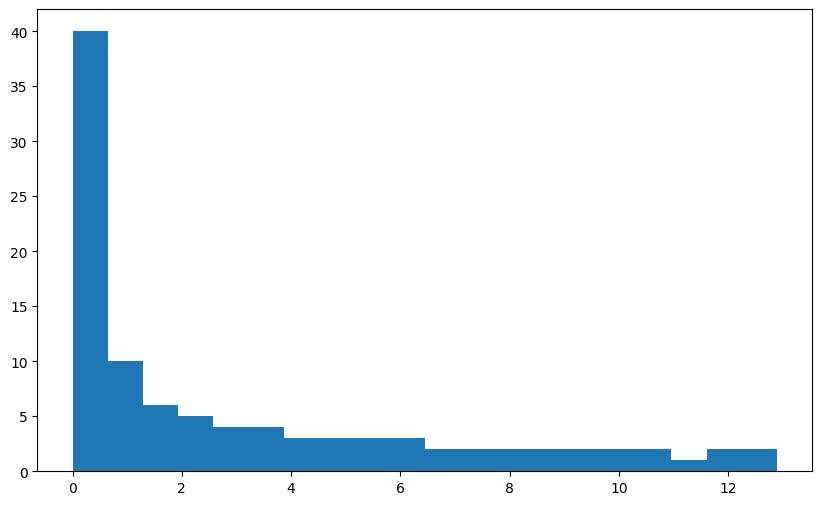

In [43]:
df_single_ab = df.filter((pl.col('a') == 4.75) & (pl.col('b') == 5.2))

fig,ax = plt.subplots(figsize=(10, 6)) 

ax.hist(df_single_ab['ur_profit_avg'], bins=20, density=False)

plt.show()

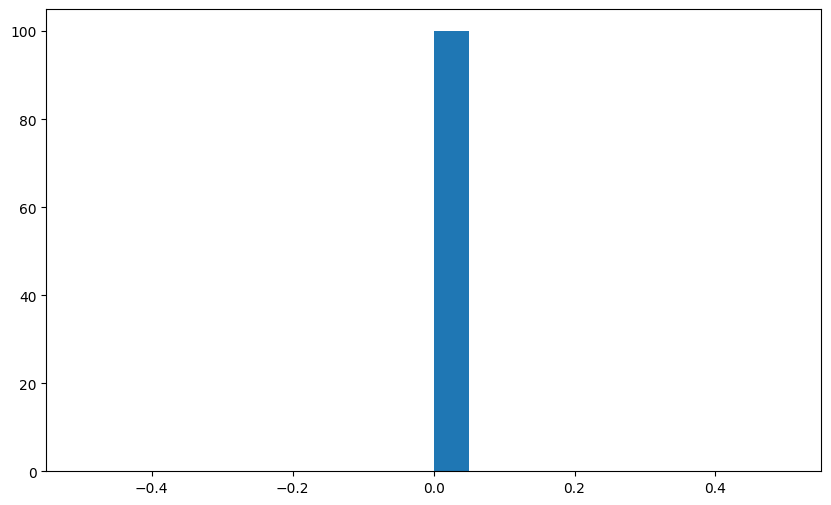

In [106]:
df_single_ab = df.filter((pl.col('a') == 4.75) & (pl.col('b') == 5.2))

fig,ax = plt.subplots(figsize=(10, 6)) 

ax.hist(df_single_ab['no_ur_profit_avg'], bins=20, density=False)

plt.show()

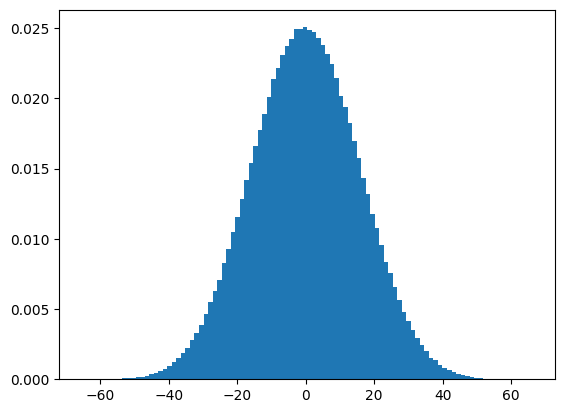

In [43]:
rng = np.random.default_rng(187293)

# Sample the true delta performance (normalize to [-100, 100])
deltas_true = rng.beta(a=20, b=20, size=1000000) * 200 - 100

plt.hist(deltas_true, bins=100, density=True)

plt.show()


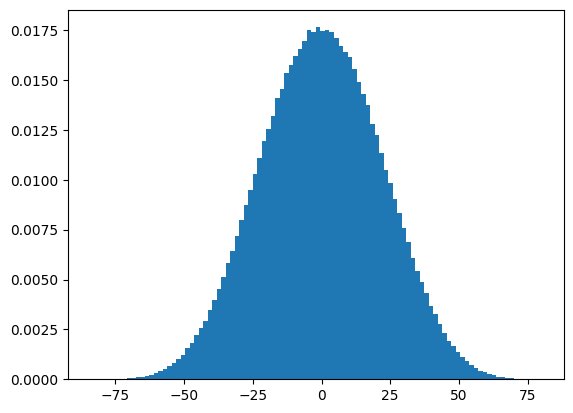

In [44]:
rng = np.random.default_rng(187293)

# Sample the true delta performance (normalize to [-100, 100])
deltas_true = rng.beta(a=10, b=10, size=1000000) * 200 - 100

plt.hist(deltas_true, bins=100, density=True)

plt.show()


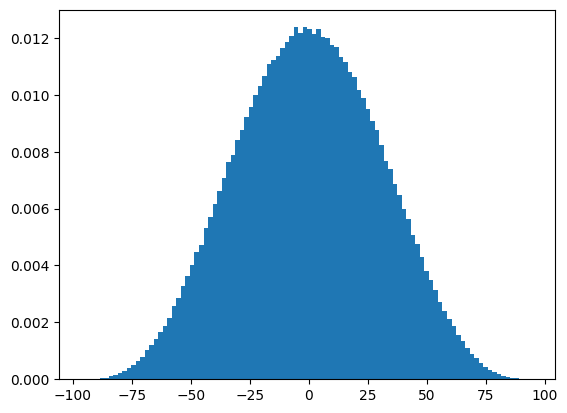

In [45]:
rng = np.random.default_rng(187293)

# Sample the true delta performance (normalize to [-100, 100])
deltas_true = rng.beta(a=5, b=5, size=1000000) * 200 - 100

plt.hist(deltas_true, bins=100, density=True)

plt.show()


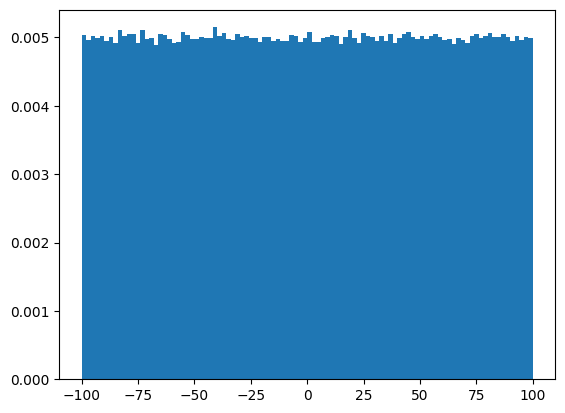

In [46]:
rng = np.random.default_rng(187293)

# Sample the true delta performance (normalize to [-100, 100])
deltas_true = rng.beta(a=1, b=1, size=1000000) * 200 - 100

plt.hist(deltas_true, bins=100, density=True)

plt.show()


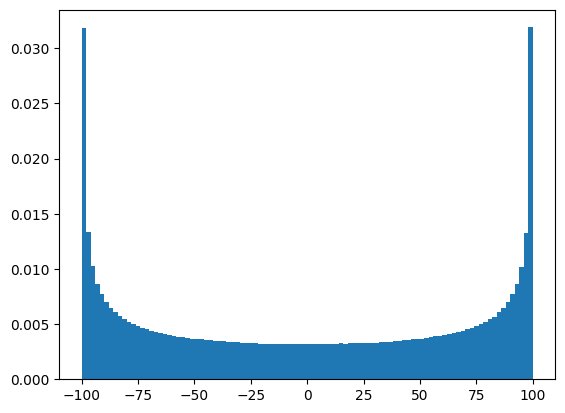

In [49]:
rng = np.random.default_rng(187293)

# Sample the true delta performance (normalize to [-100, 100])
deltas_true = rng.beta(a=0.5, b=0.5, size=10000000) * 200 - 100

plt.hist(deltas_true, bins=100, density=True)

plt.show()


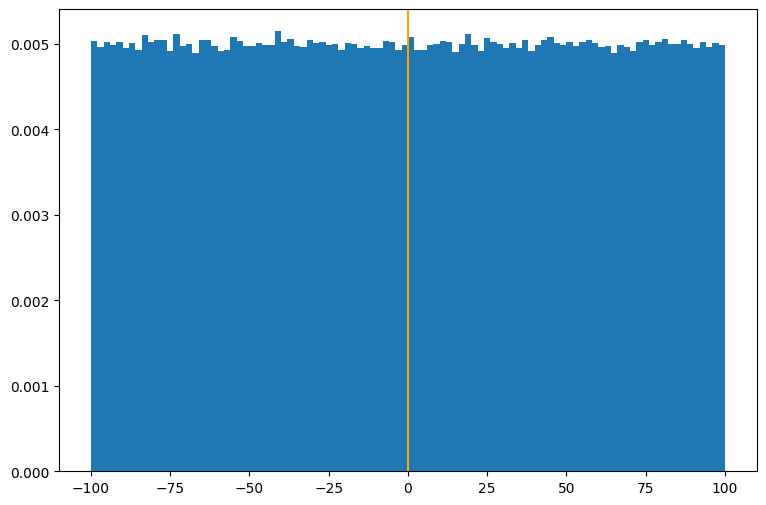

In [118]:
rng = np.random.default_rng(187293)

# Sample the true delta performance (normalize to [-100, 100])
deltas_true = rng.beta(a=1, b=1, size=1000000) * 200 - 100

plt.hist(deltas_true, bins=100, density=True)

plt.axvline(x=deltas_true.mean(), color='orange')


plt.show()


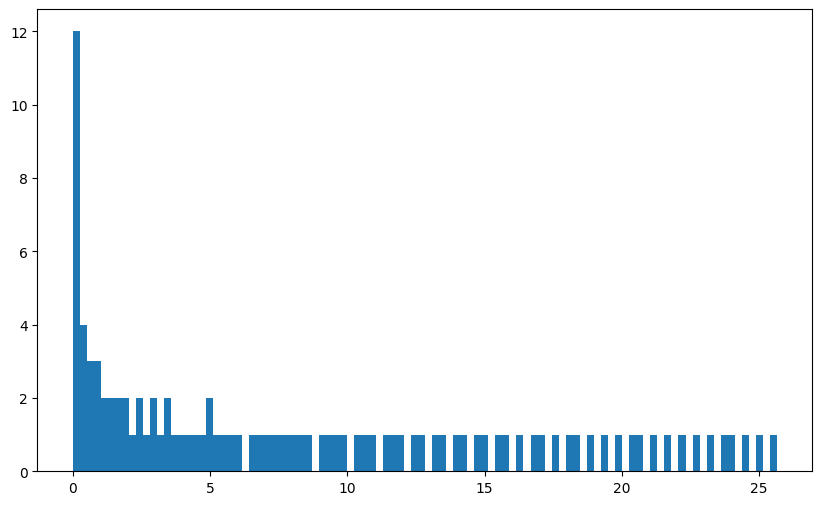

In [120]:
df_single_ab = df.filter((pl.col('a') == 1) & (pl.col('b') == 1))

fig,ax = plt.subplots(figsize=(10, 6)) 

ax.hist(df_single_ab['ur_profit_avg'], bins=100, density=False)

plt.show()

In [122]:
df_single_ab['ur_profit_avg'].mean()

8.507135616301913

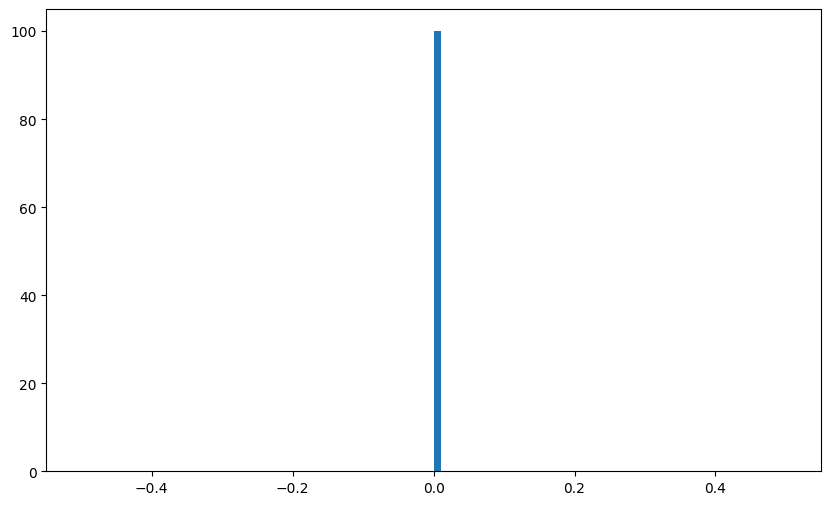

In [121]:
df_single_ab = df.filter((pl.col('a') == 1) & (pl.col('b') == 1))

fig,ax = plt.subplots(figsize=(10, 6)) 

ax.hist(df_single_ab['no_ur_profit_avg'], bins=100, density=False)

plt.show()

### Profit distribution w.r.t. a, for a fixed price

In [ ]:
df_single_ab = df.filter((pl.col('a') == 4.75) & (pl.col('b') == 5.2))

fig,ax = plt.subplots(figsize=(10, 6)) 

ax.hist(df_single_ab['ur_profit_avg'], bins=20, density=False)

plt.show()

In [95]:
price = 10
df_fixed_price = df.filter(pl.col('price') == price)
df_fixed_price

shape: (39601, 5)
┌──────┬──────┬───────┬──────────────────┬───────────────┐
│ a    ┆ b    ┆ price ┆ no_ur_profit_avg ┆ ur_profit_avg │
│ ---  ┆ ---  ┆ ---   ┆ ---              ┆ ---           │
│ f64  ┆ f64  ┆ f64   ┆ f64              ┆ f64           │
╞══════╪══════╪═══════╪══════════════════╪═══════════════╡
│ 0.05 ┆ 0.05 ┆ 10.0  ┆ 0.0              ┆ 43.352967     │
│ 0.05 ┆ 0.1  ┆ 10.0  ┆ 0.0              ┆ 27.030999     │
│ 0.05 ┆ 0.15 ┆ 10.0  ┆ 0.0              ┆ 18.778535     │
│ 0.05 ┆ 0.2  ┆ 10.0  ┆ 0.0              ┆ 14.196498     │
│ …    ┆ …    ┆ …     ┆ …                ┆ …             │
│ 9.95 ┆ 9.8  ┆ 10.0  ┆ 0.0              ┆ 10.239734     │
│ 9.95 ┆ 9.85 ┆ 10.0  ┆ 0.0              ┆ 10.106652     │
│ 9.95 ┆ 9.9  ┆ 10.0  ┆ 0.0              ┆ 9.975659      │
│ 9.95 ┆ 9.95 ┆ 10.0  ┆ 0.0              ┆ 9.845881      │
└──────┴──────┴───────┴──────────────────┴───────────────┘

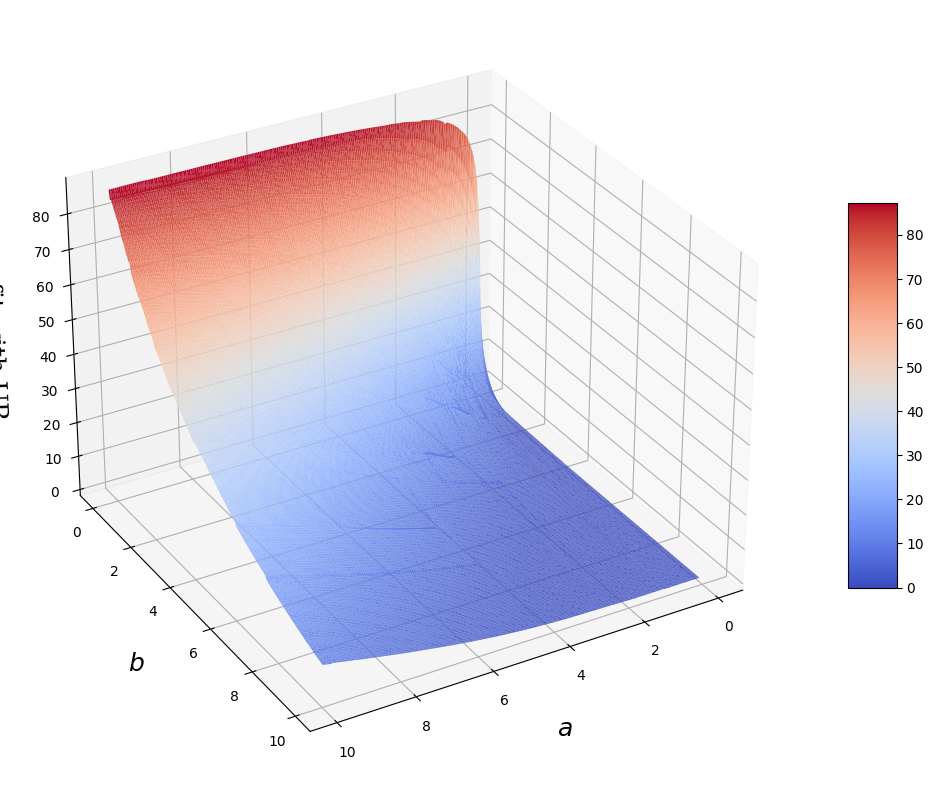

In [96]:
fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection='3d')

a = df_fixed_price['a'].to_numpy()
b = df_fixed_price['b'].to_numpy()
ur_profit_avg = df_fixed_price['ur_profit_avg'].to_numpy()

surf = ax.plot_trisurf(a, b, ur_profit_avg, cmap=plt.cm.coolwarm)

# Set axes label
fontdict = {
  'family': 'serif',
  'color':  'black',
  'weight': 'normal',
  'size': 18,
}
ax.set_xlabel('$a$', labelpad=15, fontdict=fontdict)
ax.set_ylabel('$b$', labelpad=15, fontdict=fontdict)
ax.set_zlabel('profit with UR', labelpad=15, fontdict=fontdict)

ax.view_init(30, 60)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.tight_layout()
plt.show()

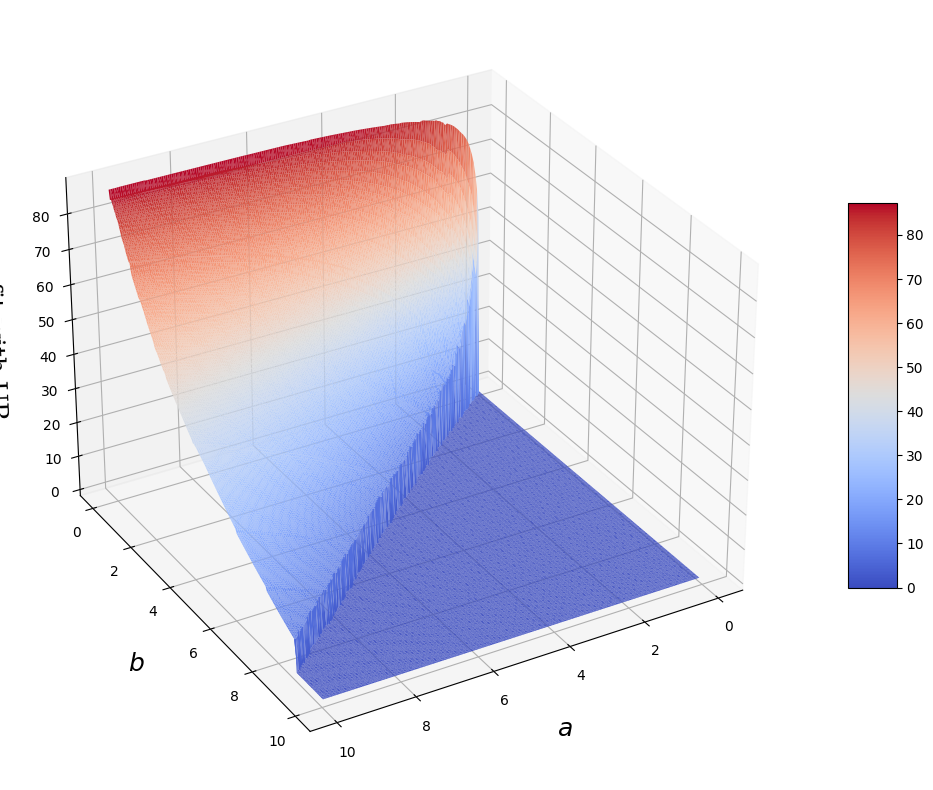

In [97]:
fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection='3d')

a = df_fixed_price['a'].to_numpy()
b = df_fixed_price['b'].to_numpy()
ur_profit_avg = df_fixed_price['no_ur_profit_avg'].to_numpy()

surf = ax.plot_trisurf(a, b, ur_profit_avg, cmap=plt.cm.coolwarm)

# Set axes label
fontdict = {
  'family': 'serif',
  'color':  'black',
  'weight': 'normal',
  'size': 18,
}
ax.set_xlabel('$a$', labelpad=15, fontdict=fontdict)
ax.set_ylabel('$b$', labelpad=15, fontdict=fontdict)
ax.set_zlabel('profit with UR', labelpad=15, fontdict=fontdict)

ax.view_init(30, 60)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.tight_layout()
plt.show()

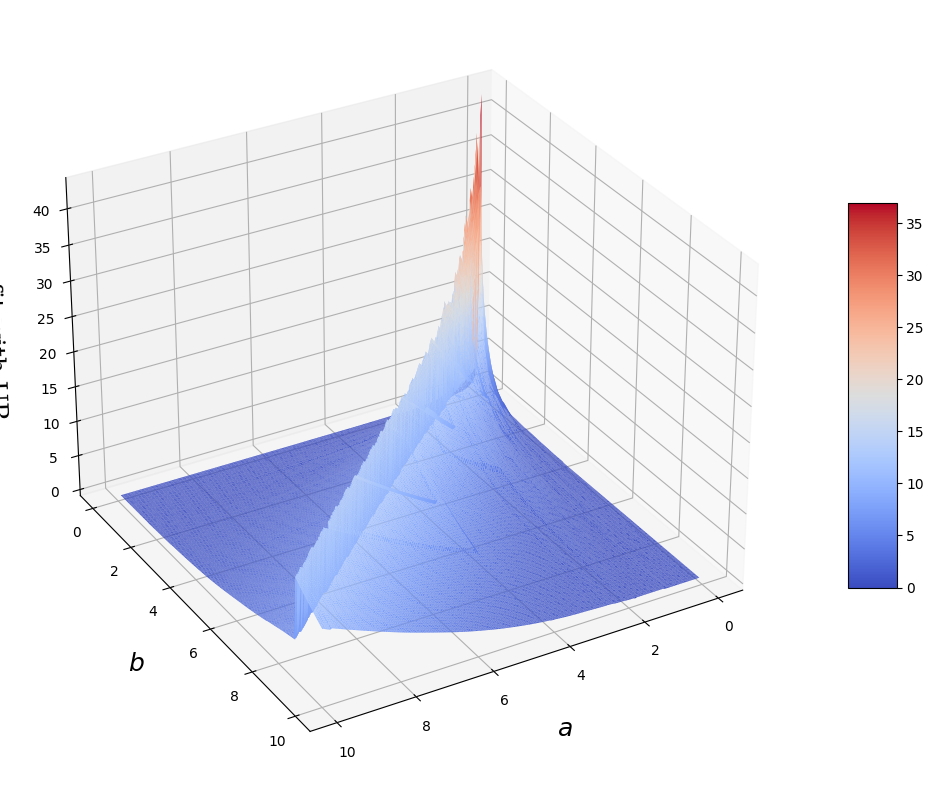

In [98]:
fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection='3d')

a = df_fixed_price['a'].to_numpy()
b = df_fixed_price['b'].to_numpy()
diff = df_fixed_price['ur_profit_avg'].to_numpy() - df_fixed_price['no_ur_profit_avg'].to_numpy()

surf = ax.plot_trisurf(a, b, diff, cmap=plt.cm.coolwarm)

# Set axes label
fontdict = {
  'family': 'serif',
  'color':  'black',
  'weight': 'normal',
  'size': 18,
}
ax.set_xlabel('$a$', labelpad=15, fontdict=fontdict)
ax.set_ylabel('$b$', labelpad=15, fontdict=fontdict)
ax.set_zlabel('profit with UR', labelpad=15, fontdict=fontdict)

ax.view_init(30, 60)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.tight_layout()
plt.show()